# Using `ArviZ` for Plotting and Chain Statistics

I wrote up a short example for using `ArviZ` to examine MCMC chains. The plotting is fairly nice, but the main usefulness I think comes with the different convergence and diagnostic tests. Most of the tests need multiple chains to work, so keep that in mind. There are also way more options than I put here, but this is just a start!

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os, glob
from collections import OrderedDict
import numpy as np
import arviz as az
import enterprise
from enterprise.pulsar import Pulsar

import warnings
warnings.filterwarnings('ignore')

# 5-yr Examples

To give the chains and their corresponding parameters to `ArviZ`, I found that the easiest way is to associate each chain/posterior with the name of the parameter. So I use the same parameters as in `la_forge`'s `fancy_par_names` as the dict keys, then use `get_param` to pull out the corresponding chain and assign them as the dict values. To convert to the `ArviZ` format, you can just call `az.convert_to_inference_data` on the created dictionary.

To see the summary of each parameters' chain, you can call `az.summary`. To select particular parameters you just pick out the `var_names` that correspond to the dictionary keys.

The less obvious columns correspond to:
* `hpd`:  highest posterior density (HPD) of array for given credible_interval

`plot_trace` give the distribution and the traceplot all in nice subplots.
If you have multiple of the same runs, `plot_trace` will overplot the two. Plus, with multiple "identical" runs, `ArviZ` can start running diagnostics on the the two chains.

This function makes a corner plot for the data, the variable selection is the same as above. You can also change the style with kind: 'kde' are smooth, 'scatter' are individual points in the parameter space, and 'hexbin' bins the data into hex bins

If you don't want to use `la_forge`, you can also load in the chains this way. In addition to the parameter names I defined earlier, you can also just load in the `pars.txt` file in the chain directory

```
chain_J2317_tm_run_1 = np.loadtxt(chaindir_J2317_tm_run_1 + '/chain_1.txt')
burn_J2317_tm_run_1 = int(0.25 * chain_J2317_tm_run_1.shape[0])
chain_J2317_tm_run_1 = chain_J2317_tm_run_1[burn_J2317_tm_run_1:]

chain_dict_J2317_tm_run_1 = {}
for i,par in enumerate(tmparam_list_J2317):
    chain_dict_J2317_tm_run_1[par] = chain_J2317_tm_run_1[:,i]
az_J2317_from_chains = az.convert_to_inference_data(chain_dict_J2317_tm_run_1)
```

In [24]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index("akaiser")
#top_path_idx = splt_path.index("nanograv")
top_dir = "/".join(splt_path[0 : top_path_idx + 1])

psr = 'J1640+2224'#'J2317+1439' 'J1909-3744'

num_chains = 1

psrlist = [psr]
datarelease = '9yr'
datadir = top_dir + '/{}'.format(datarelease)

parfiles = sorted(glob.glob(datadir + '/par/*.par'))
timfiles = sorted(glob.glob(datadir + '/tim/*.tim'))

# filter
parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0].split('_')[0] in psrlist]
timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0].split('_')[0] in psrlist]

epsr = Pulsar(parfiles[0], timfiles[0], ephem='DE436', clk=None, drop_t2pulsar=False)
"""psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem='DE436', clk=None, drop_t2pulsar=False)
    psrs.append(psr)"""
print(epsr.name)

J1640+2224


In [25]:
pardict = {}
for par,vals,errs in zip(epsr.fitpars[1:],epsr.t2pulsar.vals(),epsr.t2pulsar.errs()):
    pardict[par] = {}
    pardict[par]['val'] = vals
    pardict[par]['err'] = errs

# Multiple Chains

If you want to compare multiple of the same runs, you will need to load in the other chains and combine them in a different dictionary to load into `ArviZ`.

In [26]:
"""tmparam_list = [r'327G_ASP Efac', '327G_ASP $\mathrm{log}_{10}$Ecorr',
                        '327G_ASP $\mathrm{log}_{10}$Equad', '430G_ASP Efac',
                        '430G_ASP $\mathrm{log}_{10}$Ecorr', '430G_ASP $\mathrm{log}_{10}$Equad',
                        'Red Noise Gamma','Red Noise $\mathrm{log}_{10}$A',
                        'PBDOT',
                        'PB','A1', 'EPS1', 'EPS2', 'EPS1DOT', 'EPS2DOT',
                        'PMRA', 'PMDEC',
                        'RAJ', 'DECJ','PX',
                        'F0', 'F1',
                        'lnlike','lnprior', 'chain accept', 'pt chain accept']"""
tmparam_list = [r'Rcvr1_2_GASP Efac', 'Rcvr1_2_GASP $\mathrm{log}_{10}$Ecorr',
                        'Rcvr1_2_GASP $\mathrm{log}_{10}$Equad', 'Rcvr_800_GASP Efac',
                        'Rcvr_800_GASP $\mathrm{log}_{10}$Ecorr', 'Rcvr_800_GASP $\mathrm{log}_{10}$Equad',
                        'Red Noise Gamma','Red Noise $\mathrm{log}_{10}$A',
                        'PBDOT',
                        'PB','A1', 'EPS1', 'EPS2', 'M2',
                        'PMRA', 'PMDEC',
                        'RAJ', 'DECJ','PX',
                        'F0', 'F1',
                        'lnlike','lnprior', 'chain accept', 'pt chain accept']

use_tmparam_list = False
chaindir_list = []
#big_chaindir = os.getcwd()+'/chains/{}_all_var'.format(psr)
for i in [1]:
    chaindir_list.append(os.getcwd()+'/chains/{}/{}_all_var_{}'.format(datarelease,psr,i))

In [27]:
print(chaindir_list)

['/hyrule/data/users/akaiser/enterprise_timing/chains/9yr/J1640+2224_all_var_1']


In [28]:
chain_list = []
for chaindir in chaindir_list:
    if not use_tmparam_list:
        tmparam_list = list(np.loadtxt(chaindir + '/pars.txt',dtype='S').astype('U')) 
    chain = np.loadtxt(chaindir + '/chain_1.txt')
    burn = int(0.25 * chain.shape[0])
    chain_list.append(chain[burn:])

```
big_chain = np.loadtxt(big_chaindir + '/chain_1.txt')
big_burn = int(0.25 * big_chain.shape[0])
big_chain = big_chain[big_burn:]
```

```
division = 10
offset = 0
small_chain_len = chain_list[0].shape[0]
big_chain_len = len(big_chain)
division = int(big_chain_len/small_chain_len)
offset = big_chain_len-division*small_chain_len
offset_chain = big_chain[offset:]
for i in range(division):
    chain_list.append(offset_chain[i*small_chain_len:(i+1)*small_chain_len])
```

In [29]:
print(np.shape(chain_list))

(1, 12075, 34)


In [30]:
chain_dict = {} 
for i,par in enumerate(tmparam_list):
    for chain in chain_list:
        if par in chain_dict.keys():
            chain_dict[par] = np.concatenate((chain_dict[par],[chain[:,i]]),axis=0)
        else:
            chain_dict[par] = [chain[:,i]]
az_comb = az.convert_to_inference_data(chain_dict)

In [31]:
print(az_comb.posterior)

<xarray.Dataset>
Dimensions:                                (chain: 1, draw: 12075)
Coordinates:
  * chain                                  (chain) int64 0
  * draw                                   (draw) int64 0 1 2 ... 12073 12074
Data variables:
    J1640+2224_430_ASP_efac                (chain, draw) float64 10.0 ... 10.0
    J1640+2224_430_ASP_log10_ecorr         (chain, draw) float64 -5.0 ... -5.001
    J1640+2224_430_ASP_log10_equad         (chain, draw) float64 -6.749 ... -6.757
    J1640+2224_430_PUPPI_efac              (chain, draw) float64 8.067 ... 6.421
    J1640+2224_430_PUPPI_log10_ecorr       (chain, draw) float64 -5.001 ... -5.006
    J1640+2224_430_PUPPI_log10_equad       (chain, draw) float64 -6.114 ... -5.0
    J1640+2224_L-wide_ASP_efac             (chain, draw) float64 4.312 ... 10.0
    J1640+2224_L-wide_ASP_log10_ecorr      (chain, draw) float64 -7.611 ... -8.5
    J1640+2224_L-wide_ASP_log10_equad      (chain, draw) float64 -5.0 ... -5.0
    J1640+2224_L-wide_

Use this handy function if you would like to know what the parameter space of your chain looks like, it will show you if you loaded in the three separate chains correctly.

Since we included multiple chains, `az.summary` can run some of the provided diagnostics.

The less obvious columns correspond to:
*  `hpd` :  Highest posterior density (HPD) of array for a given credible interval
*  `mcse` : Markov Chain Standard Error statistic
*  `ess` :  Estimate of the effective sample size
*  `r_hat` :  Estimate of rank normalized splitR-hat for a set of traces

The `ArviZ` documentation points to https://arxiv.org/abs/1903.08008 for more info on both the `ess` and `r_hat` diagnostics.

In [32]:
az.summary(az_comb,var_names=tmparam_list[:-2])
#az.summary(az_comb,var_names=core_list[0].params[:-2])

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12075), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12075), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12075), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12075), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12075), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12075), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12075), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 12075), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
J1640+2224_430_ASP_efac,9.999,0.003,9.995,10.000,0.001,0.001,7.0,7.0,1.0,47.0,NaN
J1640+2224_430_ASP_log10_ecorr,-5.000,0.000,-5.001,-5.000,0.000,0.000,2.0,2.0,6.0,10.0,NaN
J1640+2224_430_ASP_log10_equad,-6.754,0.004,-6.757,-6.749,0.003,0.002,2.0,2.0,2.0,12.0,NaN
J1640+2224_430_PUPPI_efac,6.659,0.459,6.421,7.883,0.289,0.234,3.0,3.0,1.0,11.0,NaN
J1640+2224_430_PUPPI_log10_ecorr,-5.002,0.003,-5.008,-5.000,0.002,0.002,2.0,2.0,2.0,10.0,NaN
J1640+2224_430_PUPPI_log10_equad,-5.366,0.505,-6.114,-5.000,0.413,0.383,1.0,1.0,1.0,8.0,NaN
J1640+2224_L-wide_ASP_efac,8.917,1.940,4.452,10.000,1.274,1.060,2.0,2.0,1.0,10.0,NaN
J1640+2224_L-wide_ASP_log10_ecorr,-7.809,0.353,-8.500,-7.611,0.232,0.191,2.0,2.0,1.0,11.0,NaN
J1640+2224_L-wide_ASP_log10_equad,-5.001,0.002,-5.004,-5.000,0.000,0.000,18.0,18.0,9.0,23.0,NaN
J1640+2224_L-wide_PUPPI_efac,9.800,0.626,7.914,10.000,0.261,0.196,6.0,6.0,1.0,10.0,NaN


The chains are plotted on top of one another, unless you specify the particular group you wish to examine. For example, doing `coords={'chain':[2]}` looks at the third chain.

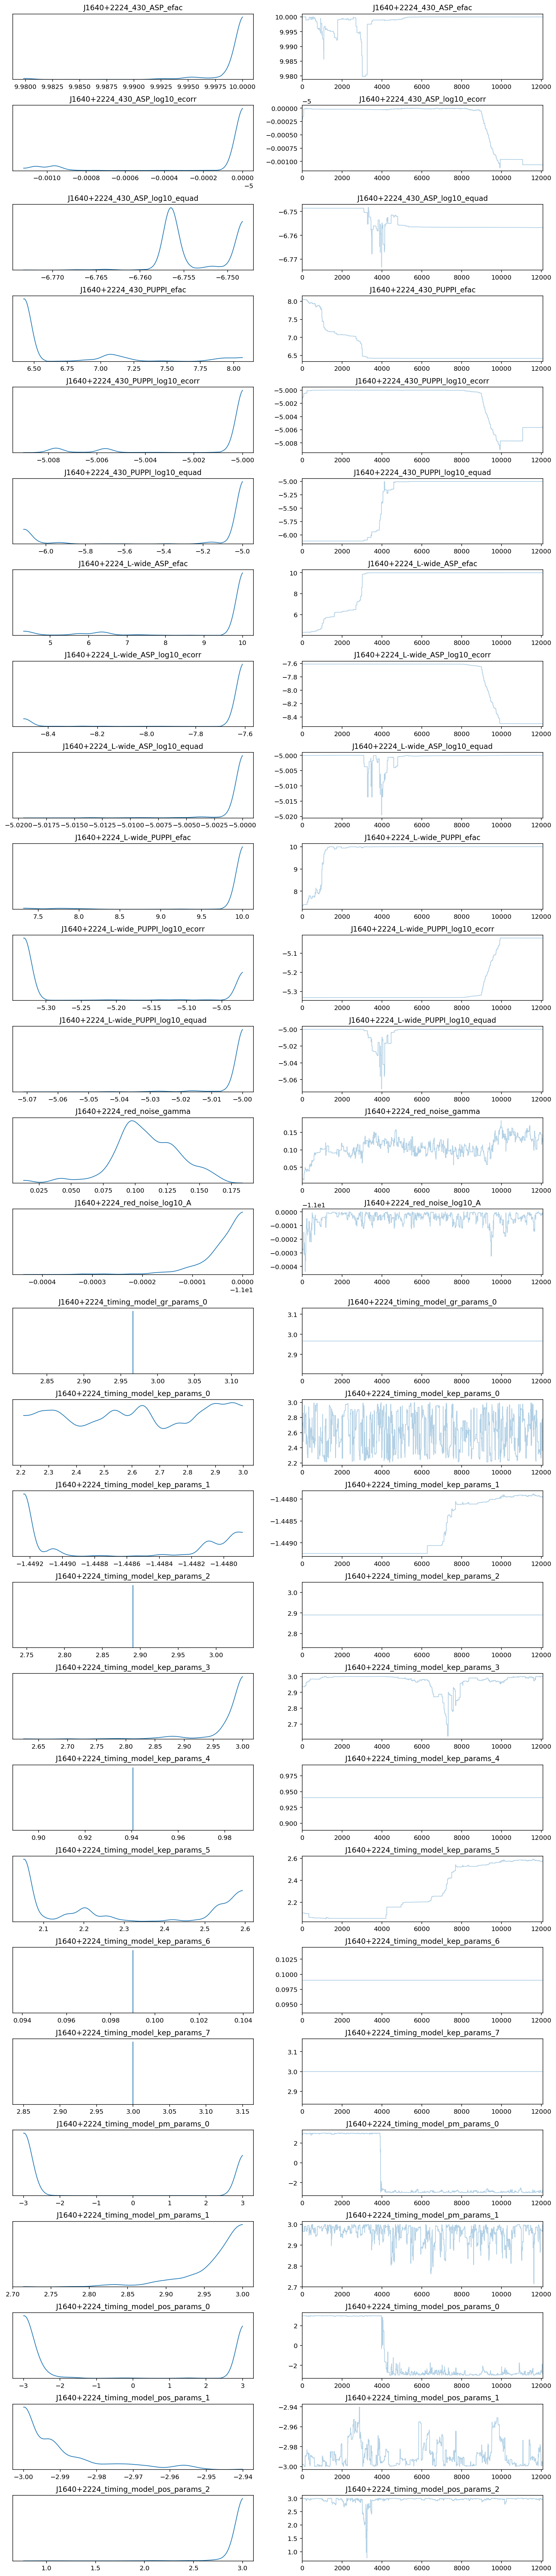

In [33]:
az.plot_trace(az_comb,
              var_names=tmparam_list[:-2]);
              #coords={'chain':[2]});

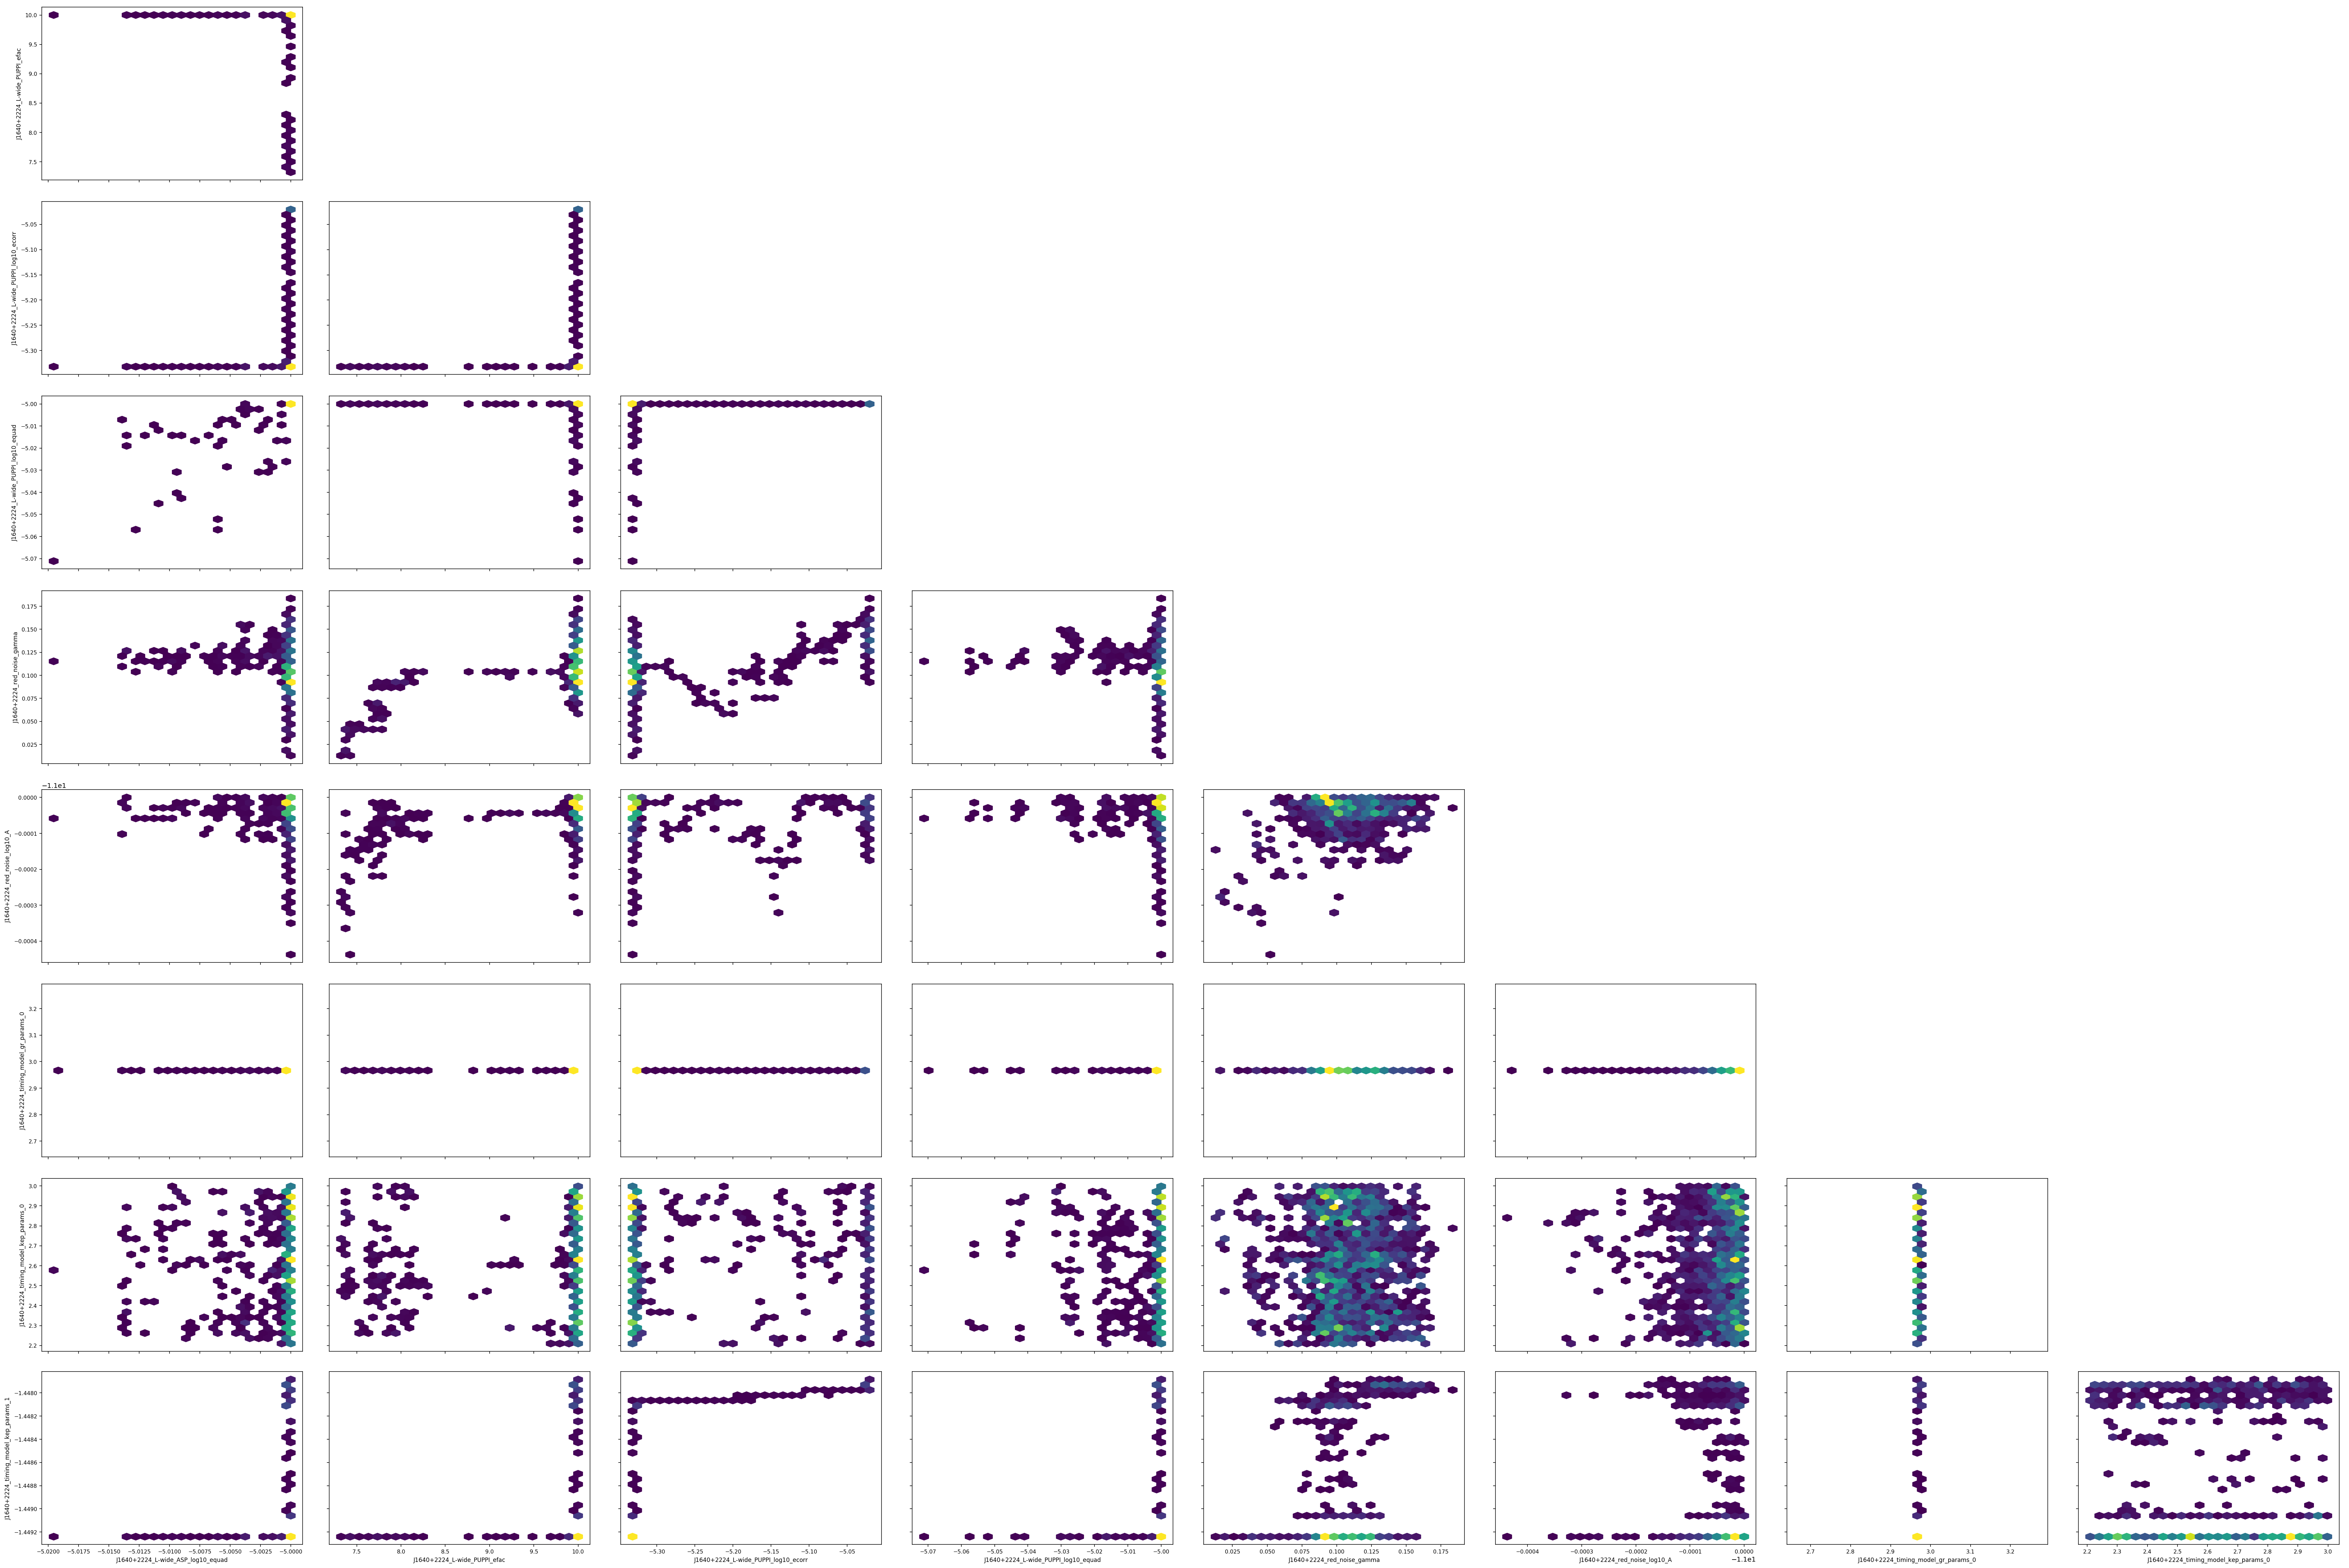

In [34]:
az.plot_pair(az_comb,
             var_names=tmparam_list[8:-2],
             coords={'chain':[0]},
             kind='hexbin',
             textsize=8);

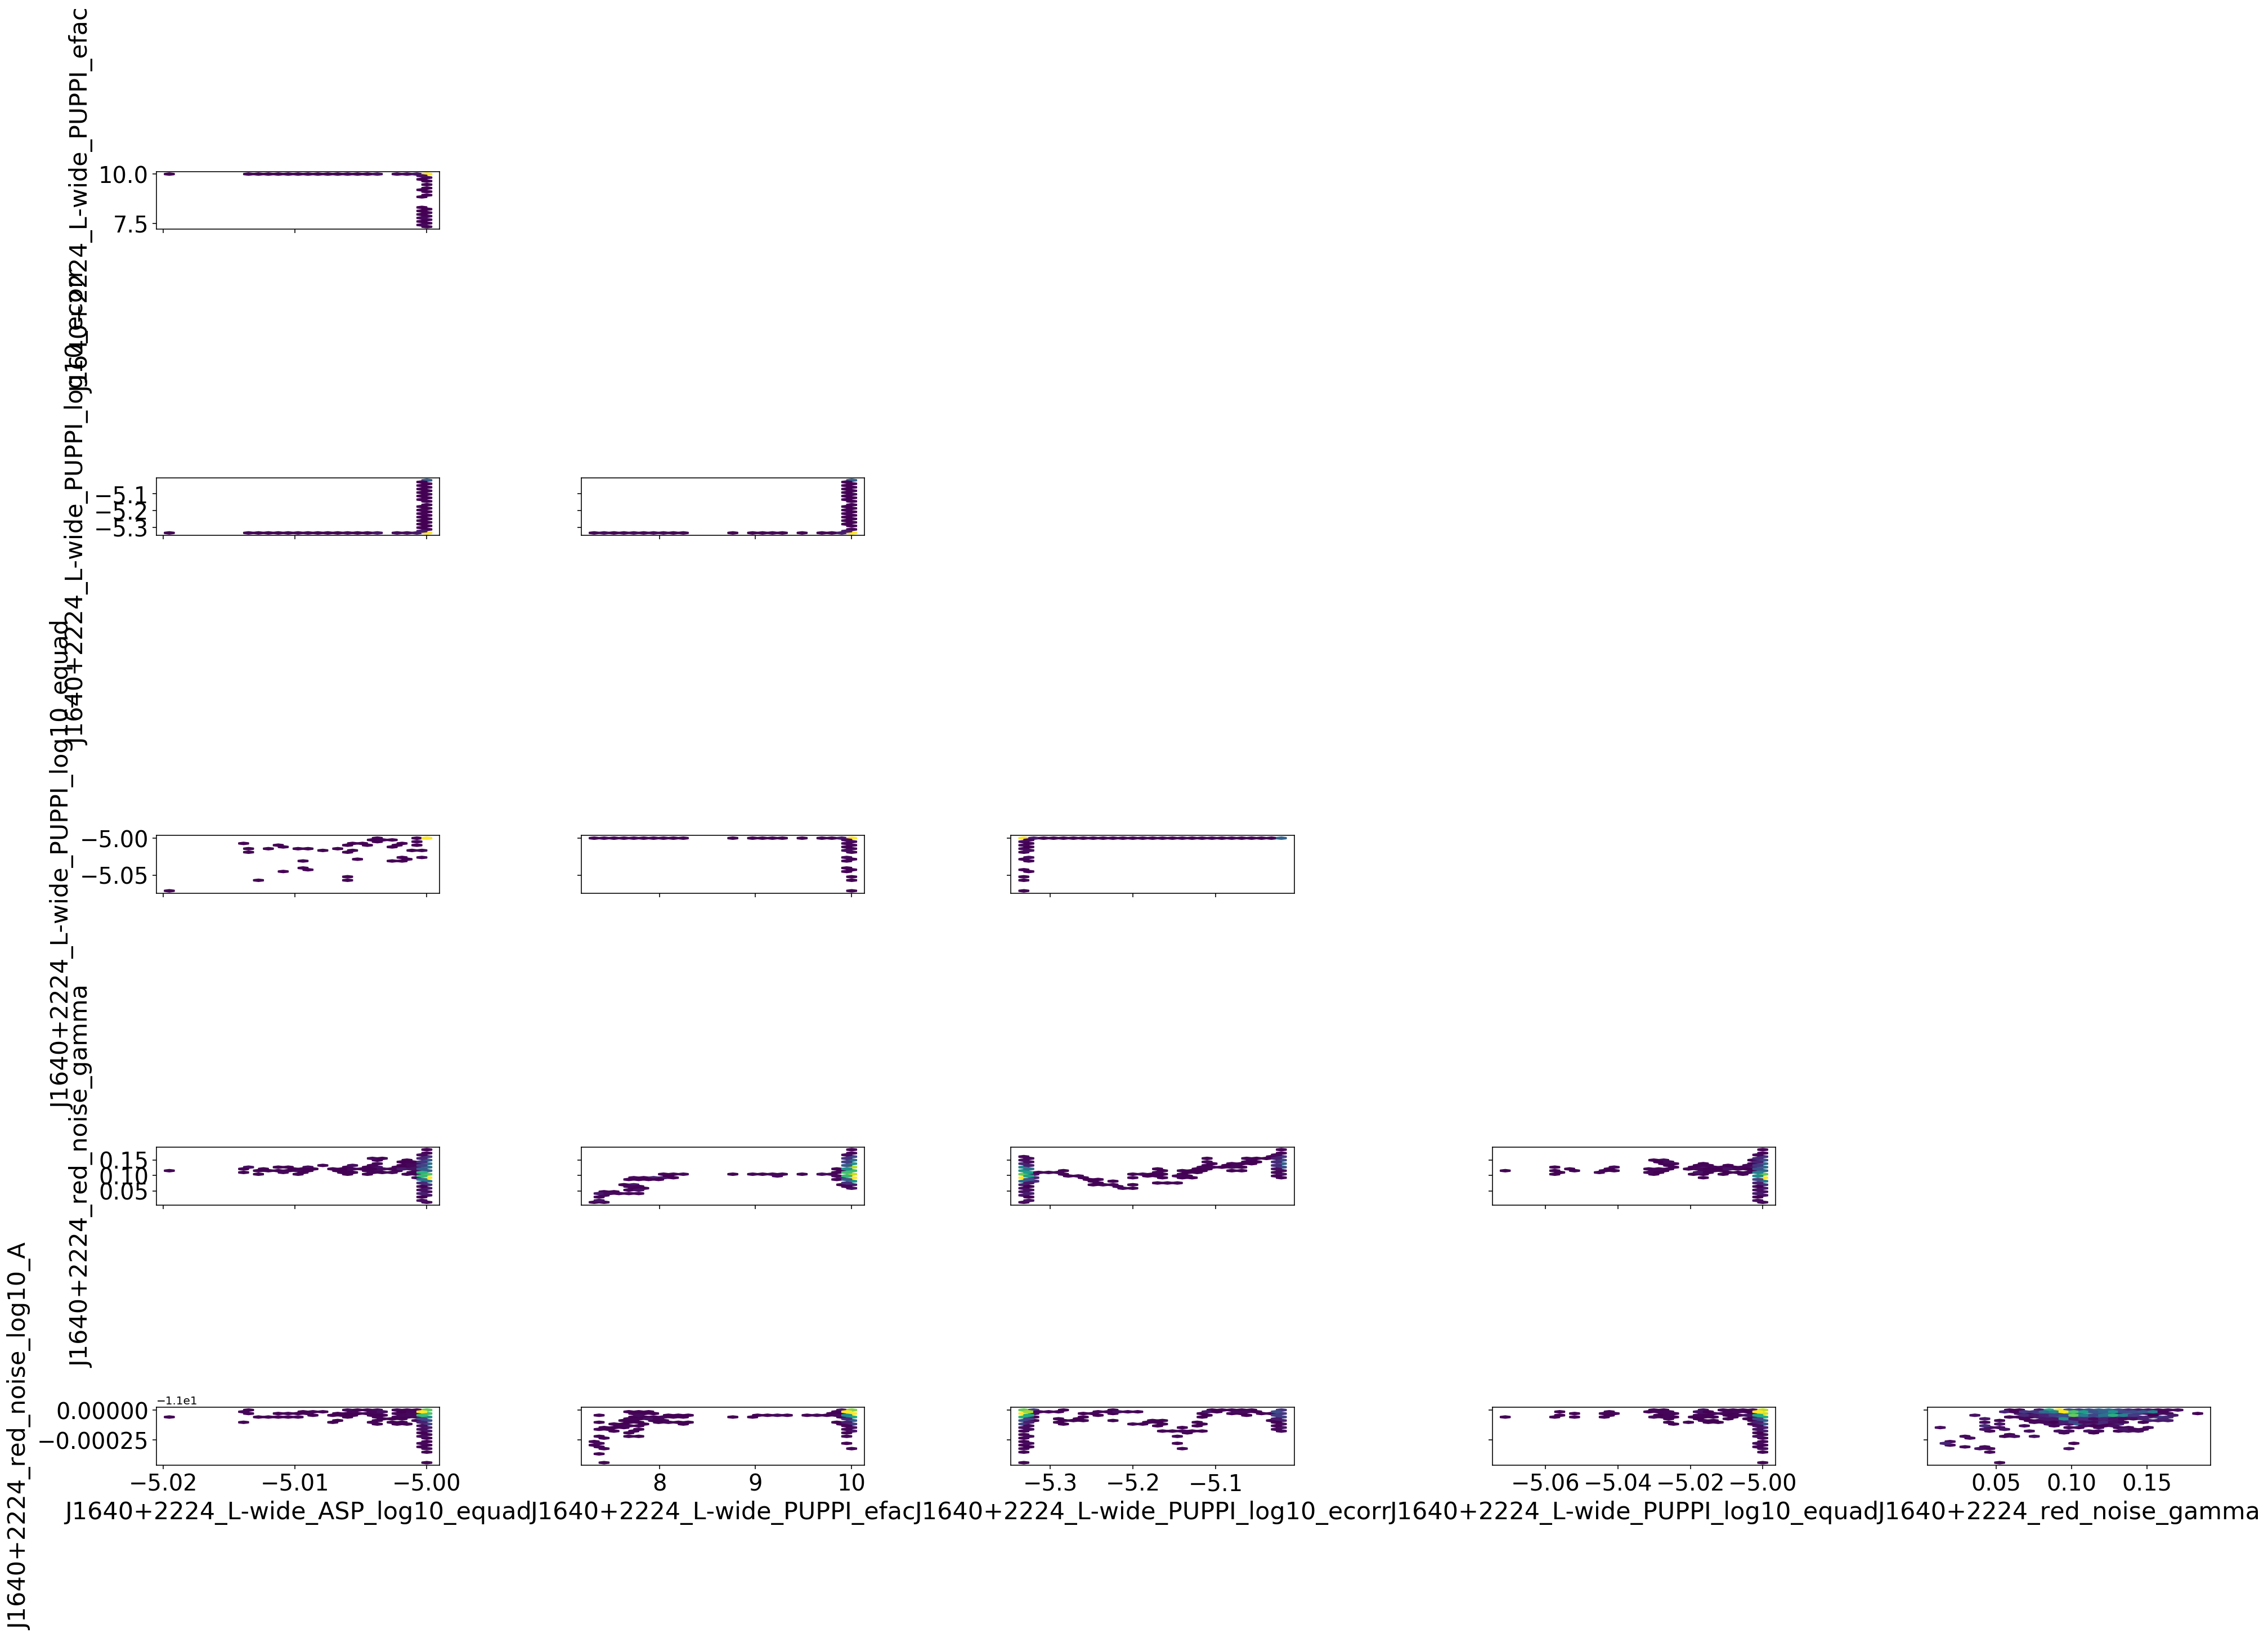

In [35]:
az.plot_pair(az_comb,
             var_names=tmparam_list[8:14],
             coords={'chain':[0]},
             kind='hexbin',
             textsize=20);